# 2024 트렌드

In [3]:
import pandas as pd
import numpy as np
from kiwipiepy import Kiwi
import copy
import re
from kiwipiepy.utils import Stopwords
import nltk

from wordcloud import WordCloud # 워드클라우드 제작 라이브러리
import pandas as pd # 데이터 프레임 라이브러리
import numpy as np # 행렬 라이브러리
import matplotlib.pyplot as plt # 워드클라우드 시각화 라이브러리
%matplotlib inline
import konlpy

In [4]:
df = pd.read_csv('../data_trend/2024년 트렌드.csv', encoding='utf-8')

# postdate, body, description, title 칼럼만 사용 
df = df[['postdate', 'body', 'description', 'title']]
df.head()

,postdate,body,description,title
0,20240518,2024년 욕실 트렌드는 고급스러운 느낌을 더해 따뜻하고 환영받는 공간을 만드는 데...,다채로운 세라믹 70년대의 오래된 <b>트렌드<\/b>가 <b>2024년<\/b>에...,공간을 창조하는 2024년 욕실 트렌드
1,20240510,안녕하세요 쟈슬린입니다. 오늘 저는 2024년 서울 머니쇼를 참석했는데요. 그 규모...,주제 : 올해 경제전망과 투자 <b>트렌드<\/b> 강사: 스티브 브라이스 (스탠다...,2024년 서울 머니쇼 관람_ 금융 .부동산. 주식. 코인. 은퇴 투자유치등 올해 ...
2,20240415,작년 10월에 올해 2024년 마케팅&소비 트렌드 TOP10을 정리해서 콘텐츠와 강...,작년 10월에 올해 <b>2024년<\/b> 마케팅&소비 <b>트렌드<\/b> TO...,"2024년 트렌드, 8. 극단사회 : 빈부격차, 생활 수준의 극단화"
3,20230922,2024 글로벌 비즈니스 트렌드 설명회 | 윤순진 - 교보문고 2024 글로벌 비즈...,"기후 위기 시대, 기후시민되기 ESG<b>트렌드<\/b> 윤순진 교수 2. <b>2...",2024년 트렌드 알아보기
4,20240523,안녕하세요. 한국중소기업경영지원센터입니다. 오늘은 청년 창업자금을 지원하는 주요 사...,이번 포스트에서는 주요한 사업 <b>트렌드<\/b>를 분석하여 알아보겠습니다. <b...,2024년 청년창업자금 지원 주요 사업 트렌드 분석


## 1. 전처리

In [5]:
# 전처리할 칼럼들
columns = ['body', 'description', 'title']

# 중복 제거
df.drop_duplicates(subset=columns, inplace=True)

for column in columns:
    # 정규표현식 - 한글, 숫자, 영어 및 공백 이외의 문자 제거
    df[column] = df[column].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]", "", regex=True)
    # 앞뒤 공백 제거
    df[column] = df[column].str.strip()
    # 여러 개의 공백을 하나의 공백으로 변경
    df[column] = df[column].str.replace(' +', " ", regex=True)

# 공백만 있는 칼럼을 NaN으로 변경 후 제거
df[columns] = df[columns].replace('', np.nan)
df.dropna(subset=columns, how='any', inplace=True)

In [6]:
from kiwipiepy import Kiwi

# Kiwi 초기화
kiwi = Kiwi()

# 불용어 리스트 정의 및 파일 로드
additional_stopwords = ['오늘', '유행', '올해', '가지', '안녕하세요', '소개', '전망', '시즌', '세계', '추천', 
                        '최신', '역할', '기업', '산업', '주목', '시작', '중요', '편안', '요소', '개발', 
                        '사용', '제공', '강조', '제품', '부동산', '수요', '증가', '관심', '기술', '규모', 
                        '가능', '사업', '느낌', '필요', '인공', '블랙', '소비자', '서비스', '관련', '지능', 
                        '생각', '색상', '모습', '전략', '경우', '시대', '때문', '주요', '정보', '사람', 
                        '동시', '기반', '핵심', '사이즈', '상품', '이후', '가격', '분야', '의미', '출시', 
                        '대비', '계획', '도움', '분석', '강화', '지역', '키워드', '중심', '공간', '발표', 
                        '기회', '진행', '구성', '방법', '업계', '판매', '세대', '이야기', '고려', '기대', 
                        '확대', '사회', '생활', '예상', '고객', '전문', '포함', '등장', '최근', '활동', 
                        '가구', '확인', '여름', '운영', '반영', '선호', '특징', '보이', '관리', '전문가', 
                        '결과', '사진', '효과', '내용', '미래', '적용', '비즈니스', '자리', '상황', '전체', 
                        '혁신', '정도', '이유', '영향', '지원', '회사', '유지', '경험', '기존', '과정', 
                        '예측', '가방', '가치', '노력', '효율', '생산', '변화', '소비', '플랫폼', '아이템', 
                        '마케팅', '성장', '소재', '관계', '방식', '기능', '데이터', '이용', '패턴', '사용자', 
                        '준비', '발전', '인하', '사랑', '대표', '네이버', '부분', '이미지', '문제', '대응', 
                        '미디어', '제작', '형태', '현실', '시스템', '업무', '여성', '가상', '국내', '현대', 
                        '보호', '마음', '요즘', '머리', '조합', '선정', '연결', '고급', '모델', '공유', '비용', 
                        '검색', '코디', '성공', '추구', '완벽', '영상', '인간', '확장', '집중', '인식', '저작',
                        '사이', '장식', '파악', '감사', '추가', '이해', '개선', '필수', '블로그', '생성', 
                        '콘텐츠', '연출', '교육', '글로벌', '달러', '포인트', '코리아', '타일', '일상', 
                        '디자이너', '업체', '향상', '광고', '스타일링', '돌봄', '에너지', '학습', '접근', 
                        '결정', '소셜', '로고', '보안', '예술', '통합', '쇼핑', '채널', '식품', '조화', 
                        '추세', '차량', '전환', '상담', '금융', '참여',  '위치', '단순', '능력', '프로젝트', 
                        '프로그램', '작업', '식물', '예약', '자동차', '수준', '솔루션', '수익', '아래', 
                        '요구', '안전', '평가', '영감', '결합', '전달'
                        ]




# 불용어 텍스트 파일에서 불용어 읽기
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords_list = file.read().splitlines()
    return stopwords_list

# 파일에서 불용어 목록 로드
stopwords_file_path = '../stopwords.txt'
file_stopwords = load_stopwords(stopwords_file_path)

# 불용어 리스트 결합
all_stopwords = set(additional_stopwords + file_stopwords)

In [7]:
# 불용어 제거 함수 정의
def remove_stopwords(text, stopwords):
    tokens = kiwi.tokenize(text)
    filtered_tokens = [token.form for token in tokens if token.form not in stopwords]
    return ' '.join(filtered_tokens)

# 전처리 함수 정의
def preprocess_korean(text, analyzer=kiwi, stopwords=all_stopwords):
    my_text = copy.copy(text)
    my_text = my_text.replace('\n', ' ') # (1) 줄바꿈 문자 제거
    my_text = analyzer.space(my_text) # (2) 띄어쓰기 교정
    sents = analyzer.split_into_sents(my_text) # (3) 문장 토큰화
    p = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]')
    all_result = []
    for sent in sents:
        token_result = remove_stopwords(sent.text, stopwords) # (4) 형태소 분석 및 불용어 제거
        token_result = p.sub(' ', token_result) # (5) 특수 문자 제거 (=한글을 제외한 문자 제거)
        all_result.append(token_result) # (6) 형태소 분석한 결과를 다시 join
    
    all_result = ' '.join(all_result) # (7) 모든 문장을 하나의 string으로 join

    return all_result

# 품사(명사, 동사, 형용사, 부사) 추출 함수 정의
def wordclass_korean(my_str, kiwi=kiwi):
    result = []
    tokens = kiwi.tokenize(my_str, normalize_coda=True)
    for token in tokens:
        if token.tag in ['NNG', 'NNP', 'NNB']:  # 명사 태그만 추출
            result.append(token.form)
    result = ' '.join(result)
    return result

In [8]:
%%time
# 전처리 함수 적용
for column in columns:
    preprocessed_column = 'preprocessed_' + column 
    df[preprocessed_column] = df[column].apply(lambda x: preprocess_korean(x))

# 품사 추출 함수 적용
preprocessed_columns = ['preprocessed_body', 'preprocessed_title', 'preprocessed_description']
for column in preprocessed_columns:
    df[column] = df[column].apply(wordclass_korean)

df.head()

CPU times: total: 2min 15s
Wall time: 6min 7s


,postdate,body,description,title,preprocessed_body,preprocessed_description,preprocessed_title
0,20240518,2024년 욕실 트렌드는 고급스러운 느낌을 더해 따뜻하고 환영받는 공간을 만드는 데...,다채로운 세라믹 70년대의 오래된 b트렌드b가 b2024년b에 다시 돌아오고 있으며...,공간을 창조하는 2024년 욕실 트렌드,욕실 트렌드 환영 데 중점 안식처 도 욕실 개성 독특 스타일 도 트렌드 욕실 트렌드...,세라믹 년대 트렌드 세라믹 목록 상위 악명 아보카도 욕실 스위트 대하 회상,창조 욕실 트렌드
1,20240510,안녕하세요 쟈슬린입니다 오늘 저는 2024년 서울 머니쇼를 참석했는데요 그 규모가 ...,주제 올해 경제전망과 투자 b트렌드b 강사 스티브 브라이스 스탠다드차타드 sc 그룹...,2024년 서울 머니쇼 관람 금융 부동산 주식 코인 은퇴 투자유치등 올해 경제전망과...,쟈슬린 서울 머니 쇼 참석 개막식 세미나 참석 사전 신청 후기 서울 머니 쇼 서울 ...,주제 경제 투자 트렌드 강사 스티브 브 라이스 스탠다드차타드 그룹 투자 부문 최고 ...,서울 머니 쇼 관람 주식 코 은퇴 투자 유치 경제 투자 트렌드 강의 후기
2,20240415,작년 10월에 올해 2024년 마케팅소비 트렌드 TOP10을 정리해서 콘텐츠와 강연...,작년 10월에 올해 b2024년b 마케팅소비 b트렌드b TOP10을 정리해서 콘텐츠...,2024년 트렌드 8 극단사회 빈부격차 생활 수준의 극단화,작년 트렌드 정리 강연 중순 냉정 게 점검 대로 거 말 중 극단 빈부 격차 극단 것...,작년 트렌드 정리 강연 중순 냉정 게 점검 대로,트렌드 극단 빈부 격차 극단
3,20230922,2024 글로벌 비즈니스 트렌드 설명회 윤순진 교보문고 2024 글로벌 비즈니스 트...,기후 위기 시대 기후시민되기 ESGb트렌드b 윤순진 교수 2 b2024년b 세계 경...,2024년 트렌드 알아보기,트렌드 설명회 윤 순진 교보문고 트렌드 설명회 서울대학교 사회학 공부 현재 서울대학...,기후 위기 기후 시민 트렌드 윤순지 교수 경제 경제 경영 트렌드 김광석 교수 챗 세...,트렌드
4,20240523,안녕하세요 한국중소기업경영지원센터입니다 오늘은 청년 창업자금을 지원하는 주요 사업 ...,이번 포스트에서는 주요한 사업 b트렌드b를 분석하여 알아보겠습니다 b2024년b에는...,2024년 청년창업자금 지원 주요 사업 트렌드 분석,한국 중소 경영 센터 은 청년 창업 자금 트렌드 대하 디지털 녹색 환경 트렌드 고 ...,포스트 트렌드 알 다양 되 은 청년 창업자 자금 컨설팅,청년 창업 자금 트렌드


In [9]:
# 전처리한 결과 csv로 저장 
df.to_csv('24트렌드_전처리.csv', index=False, encoding='utf-8-sig')

## 2. 단어 빈도 계산

In [10]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts

### [preprocessed_body]

In [11]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_body']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [12]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_body = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_body = all_words_body[all_words_body['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_body.head(30)
top_30_words

,word,count
14617,트렌드,5902
3141,디자인,2012
13699,컬러,1897
2647,대하,1809
2378,다양,1780
16517,활용,1648
8175,시장,1618
14907,패션,1469
7861,스타일,1469
11125,인테리어,1207


In [13]:
l = []
for i in top_30_words['word']:
    l.append(i)
l

['트렌드',
 '디자인',
 '컬러',
 '대하',
 '다양',
 '활용',
 '시장',
 '패션',
 '스타일',
 '인테리어',
 '브랜드',
 '환경',
 '지속',
 '인기',
 '개인',
 '경제',
 '자연',
 '디지털',
 '선택',
 '출처',
 '투자',
 '욕실',
 '피부',
 '건강',
 '뷰티',
 '분위기',
 '메이크업',
 '여행',
 '구매',
 '미국']

### [preprocessed_description]

In [14]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_description']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [15]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_description = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_description = all_words_description[all_words_description['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_description.head(30)
top_30_words

,word,count
2842,트렌드,1701
2686,컬러,227
2900,패션,214
2169,인테리어,158
537,대하,122
633,디자인,107
1607,시장,104
1192,뷰티,93
1541,스타일,92
127,경제,72


### [preprocessed_title]

In [16]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_title']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [17]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_title = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_title = all_words_title[all_words_title['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_title.head(30)
top_30_words

,word,count
1274,트렌드,1011
1309,패션,91
995,인테리어,89
1206,컬러,83
283,디자인,50
745,시장,45
550,뷰티,41
1164,최고,35
906,욕실,31
1422,헤어,29


## 3. 워드 클라우드

참고 사이트: https://serendipity77.tistory.com/entry/영화동감-영화동감-댓글-리뷰-워드-클라우드wordcloud로-만들어보기파이썬-Python 

[엑셀 자동화로 칼퇴하는 김대리의 고군분투기:티스토리]

In [18]:
font_path='C:\\Windows\\Fonts\\malgun.ttf'

### [body WordCloud]

In [19]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_body.set_index('word').to_dict()['count']
dic_word

{'트렌드': 5902,
 '디자인': 2012,
 '컬러': 1897,
 '대하': 1809,
 '다양': 1780,
 '활용': 1648,
 '시장': 1618,
 '패션': 1469,
 '스타일': 1469,
 '인테리어': 1207,
 '브랜드': 1143,
 '환경': 1099,
 '지속': 981,
 '인기': 918,
 '개인': 865,
 '경제': 781,
 '자연': 746,
 '디지털': 724,
 '선택': 723,
 '출처': 712,
 '투자': 653,
 '욕실': 593,
 '피부': 576,
 '건강': 552,
 '뷰티': 546,
 '분위기': 532,
 '메이크업': 515,
 '여행': 509,
 '구매': 431,
 '미국': 422,
 '매력': 420,
 '표현': 390,
 '맞춤': 389,
 '한국': 377,
 '문화': 364,
 '헤어': 361,
 '온라인': 355,
 '스마트': 330,
 '염색': 325,
 '개성': 323,
 '피치': 280,
 '독특': 278,
 '조명': 268,
 '네일': 264,
 '음악': 261,
 '레드': 256,
 '퍼즈': 255,
 '코로나': 244,
 '도시': 233,
 '브라운': 218,
 '질감': 215,
 '일본': 213,
 '완성': 211,
 '화이트': 210,
 '얼굴': 209,
 '취향': 208,
 '전통': 203,
 '클래식': 200,
 '게임': 198,
 '블루': 193,
 '아트': 192,
 '미니멀': 191,
 '중국': 185,
 '목표': 178,
 '세상': 178,
 '창의': 178,
 '년대': 177,
 '최적': 177,
 '공연': 176,
 '현상': 175,
 '방향': 175,
 '흐름': 174,
 '매치': 174,
 '오프': 173,
 '액세서리': 173,
 '핑크': 171,
 '고민': 171,
 '컬렉션': 170,
 '최고': 170,
 '정책': 169,
 '도전': 1

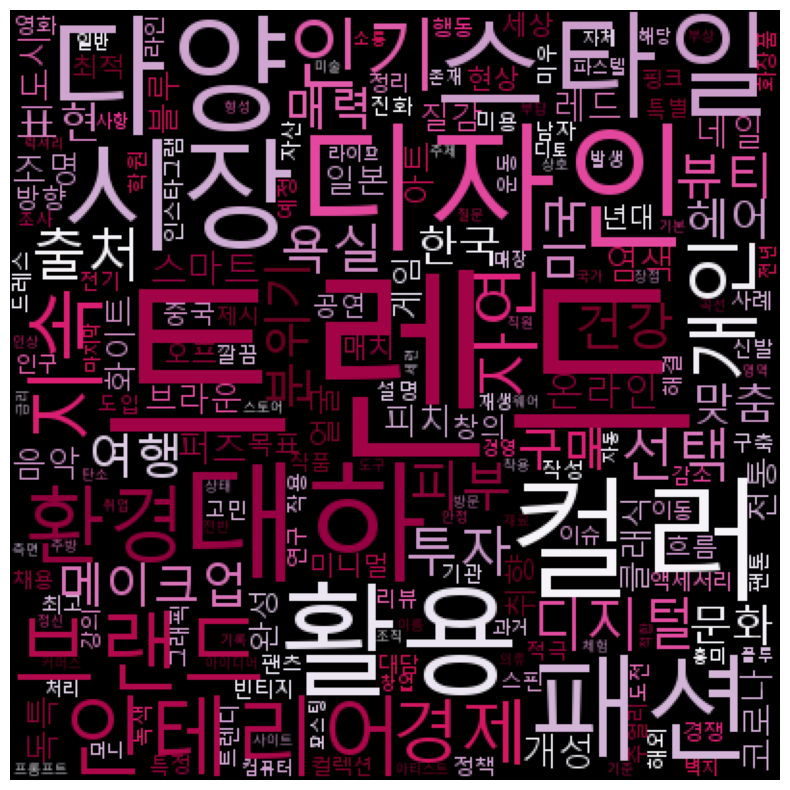

In [20]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'PuRd')
               ## 'Blues': 파란색 그라데이션
               ## 'BuGn': 청록색
               ## 'BuPu': 진보라 ~ 연한 파란색 ~ 하얀색 
               ## 'GnBu': 진파랑 ~ 연한 초록색 ~ 하얀색
               ## 'Greys': 검은색 ~ 회색 ~ 하얀색
               ## 'OrRd': 진빨강 ~ 연한 오렌지 ~ 하얀색
               ## 'Pastel1': 파스텔 색
               ## 'Pastel2': 파스텔 색
               ## 'PuBu': 진파랑 ~ 핑크 ~ 하얀색
               ## 'PuRd': 자주 ~ 핑크 ~ 하얀색
               ## 'Purples': 보라색
               ## 'RdPu': 보라 ~ 자주 ~ 핑크
               ## 'Reds': 빨강
               ## 'Wistia': 주황 ~ 형광 노랑
               ## 'YlGnBr': 파랑 ~ 초록 ~ 노랑


img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

## [description WordCloud]

In [21]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_description.set_index('word').to_dict()['count']
dic_word

{'트렌드': 1701,
 '컬러': 227,
 '패션': 214,
 '인테리어': 158,
 '대하': 122,
 '디자인': 107,
 '시장': 104,
 '뷰티': 93,
 '스타일': 92,
 '경제': 72,
 '다양': 66,
 '욕실': 65,
 '출처': 59,
 '지속': 56,
 '인기': 49,
 '활용': 49,
 '자연': 48,
 '메이크업': 48,
 '헤어': 47,
 '환경': 47,
 '디지털': 45,
 '브랜드': 42,
 '여행': 42,
 '작성': 40,
 '염색': 39,
 '한국': 38,
 '번역': 37,
 '수정': 36,
 '팬톤': 36,
 '편집': 36,
 '참조': 35,
 '투자': 33,
 '정리': 32,
 '피치': 32,
 '퍼즈': 30,
 '건강': 29,
 '레드': 28,
 '네일': 27,
 '헤어스타일': 25,
 '브라운': 24,
 '포스팅': 23,
 '선택': 22,
 '문화': 21,
 '채용': 21,
 '머니': 21,
 '강의': 19,
 '주제': 19,
 '새해': 19,
 '긱시크': 18,
 '요약': 18,
 '개인': 18,
 '동향': 17,
 '미국': 17,
 '대안': 17,
 '분위기': 17,
 '작년': 17,
 '남자': 17,
 '이슈': 16,
 '피치퍼즈': 16,
 '청룡': 16,
 '알리': 16,
 '누수': 16,
 '미용': 15,
 '미용실': 15,
 '스타트업': 15,
 '리뷰': 15,
 '리포트': 14,
 '저자': 14,
 '흐름': 14,
 '대한민국': 14,
 '남성': 14,
 '질감': 13,
 '자료': 13,
 '김용한': 13,
 '아이디어': 13,
 '경영': 13,
 '온라인': 13,
 '김난도': 13,
 '방향': 13,
 '블루': 13,
 '화이트': 13,
 '블로거': 13,
 '신발': 13,
 '표현': 12,
 '세미나': 12,
 '조명': 12,
 '수술': 12,
 '기

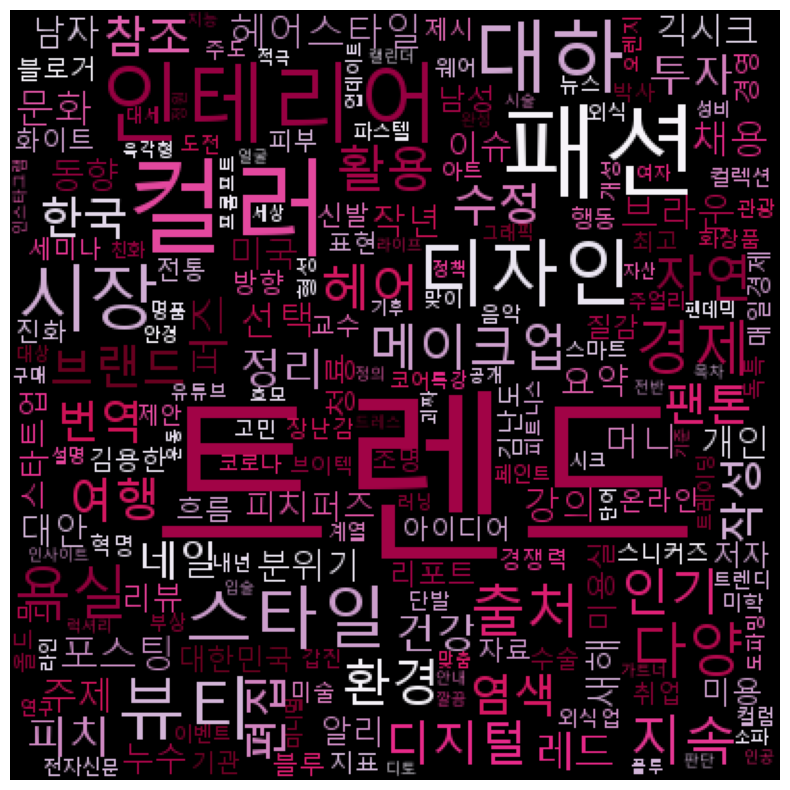

In [22]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'PuRd')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

## [title WordCloud]

In [23]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_title.set_index('word').to_dict()['count']
dic_word

{'트렌드': 1011,
 '패션': 91,
 '인테리어': 89,
 '컬러': 83,
 '디자인': 50,
 '시장': 45,
 '뷰티': 41,
 '최고': 35,
 '욕실': 31,
 '헤어': 29,
 '스타일': 28,
 '염색': 24,
 '메이크업': 24,
 '경제': 22,
 '미용실': 21,
 '남자': 18,
 '투자': 15,
 '정리': 15,
 '여행': 15,
 '이슈': 15,
 '한국': 14,
 '네일': 14,
 '인기': 14,
 '채용': 13,
 '학원': 13,
 '활용': 13,
 '브랜드': 12,
 '후기': 12,
 '신발': 12,
 '머니': 11,
 '헤어스타일': 11,
 '외식': 11,
 '창업': 10,
 '리뷰': 10,
 '아이디어': 10,
 '공개': 10,
 '레드': 9,
 '브라운': 9,
 '피치퍼즈': 9,
 '특강': 9,
 '디지털': 9,
 '스니커즈': 9,
 '긱시크': 8,
 '피치': 8,
 '미국': 8,
 '대한민국': 8,
 '서울': 8,
 '취업': 8,
 '환경': 8,
 '미용': 8,
 '팬톤': 7,
 '대하': 7,
 '퍼즈': 7,
 '공지': 7,
 '요약': 7,
 '예감': 7,
 '흐름': 7,
 '청룡': 7,
 '동향': 6,
 '새해': 6,
 '여자': 6,
 '스타트업': 6,
 '교수': 6,
 '모집': 6,
 '뉴스': 6,
 '알리': 6,
 '퍼스널': 6,
 '경영': 6,
 '남성': 6,
 '대구': 6,
 '안경': 6,
 '그래픽': 6,
 '화장품': 6,
 '디토소비': 6,
 '운동화': 6,
 '조명': 5,
 '강연': 5,
 '문화': 5,
 '트레이딩': 5,
 '단발': 5,
 '샌들': 5,
 '농산물': 5,
 '세미나': 5,
 '가이드': 5,
 '수술': 5,
 '자연': 5,
 '제목': 5,
 '미술': 5,
 '외식업': 5,
 '웨딩': 5,
 '울산': 5,
 '주도': 5,
 '주얼리

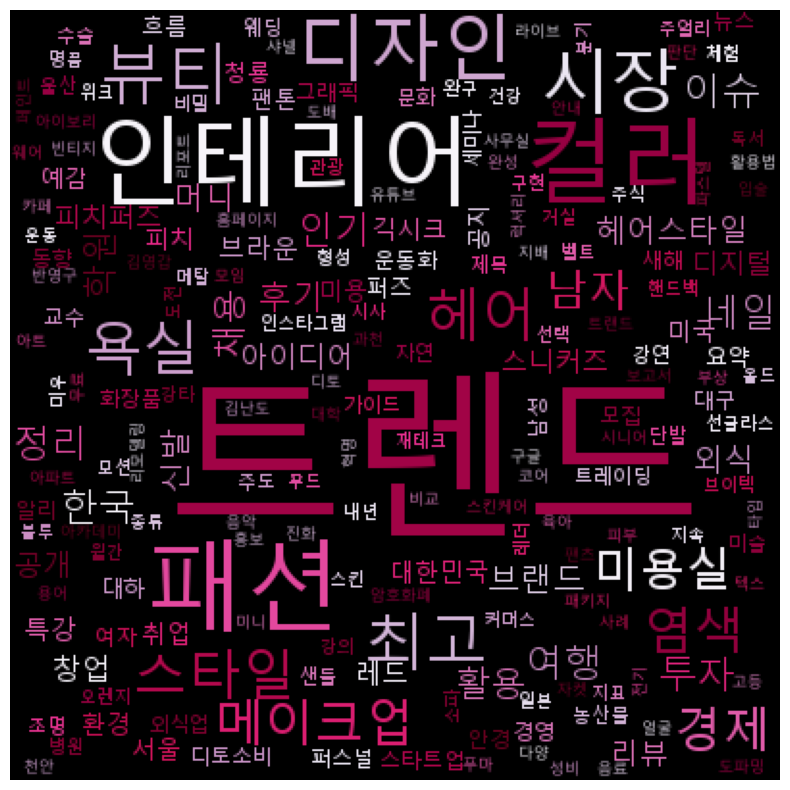

In [24]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'PuRd')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기